# Clustering Sc-10x data

There are 1581 cells to be analyzed. <br>
Please refer to:
file:///Users/waynewu/4.Github/Clustering-for-scRNAseq/dataset/sc-10x/web_summary.html

n_obs: number of cells <br>
n_vars: number of features

### adata:
n_obs x n_vars (1581 x 33538)
1. use indexing and .X to get data. 
   
   Ex. 
       adata[:, meta].X, 
       adata.obs['n_genes']
       adata.var['n_features']
2. matrix.A1: transform to ndarray

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


# Preprocess the labels

In [5]:
import os
path = './dataset/sc-10x/GSE111108_RAW'
if os.path.exists(path):
    files = os.listdir('dataset/sc-10x/GSE111108_RAW')
ground_truth1 = pd.read_csv(os.path.join(path, files[1]))
ground_truth2 = pd.read_csv(os.path.join(path, files[2]), names=['cell_name', 'barcode', 'ref'])

In [6]:
ground_truth1.head(5)

,cell_name,cell_line_demuxlet,demuxlet_cls
0,CELL_001266,H1975,SNG
1,CELL_001391,H2228,DBL
2,CELL_002843,HCC827,DBL
3,CELL_000432,H2228,SNG
4,CELL_001720,HCC827,DBL


In [7]:
ground_truth2.head(5)

,cell_name,barcode,ref
0,CELL_000000,CCTTACGAGGACACCA,864365
1,CELL_000001,CCGTTCAGTACGACCC,755167
2,CELL_000002,TGAAAGACACTGTTAG,753727
3,CELL_000003,CTGAAACAGAGACTAT,750591
4,CELL_000004,GACTGCGCACGAAACG,718276


In [8]:
table = ground_truth2.merge(ground_truth1, on='cell_name')
table.head(10)

,cell_name,barcode,ref,cell_line_demuxlet,demuxlet_cls
0,CELL_000001,CCGTTCAGTACGACCC,755167,HCC827,SNG
1,CELL_000002,TGAAAGACACTGTTAG,753727,HCC827,DBL
2,CELL_000003,CTGAAACAGAGACTAT,750591,HCC827,SNG
3,CELL_000004,GACTGCGCACGAAACG,718276,HCC827,SNG
4,CELL_000005,AGCAGCCTCCTCGCAT,701393,HCC827,SNG
5,CELL_000006,TTCTCAAGTTACGACT,665628,H1975,SNG
6,CELL_000007,AGTGTCAGTATCTGCA,663212,HCC827,SNG
7,CELL_000008,TGAGAGGAGATCGATA,656593,HCC827,SNG
8,CELL_000009,TTCGAAGGTTCCGTCT,652084,HCC827,SNG
9,CELL_000010,CTCATTACATTCCTCG,651956,HCC827,SNG


# Start

In [17]:
# Read in th data
adata = sc.read_10x_mtx(
    './dataset/sc-10x/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)     

... reading from cache file cache/dataset-sc-10x-filtered_feature_bc_matrix-matrix.h5ad


In [18]:
adata

View of AnnData object with n_obs × n_vars = 1581 × 33538 
    var: 'gene_ids', 'feature_types'

# Preprocessing the data

### 1. Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


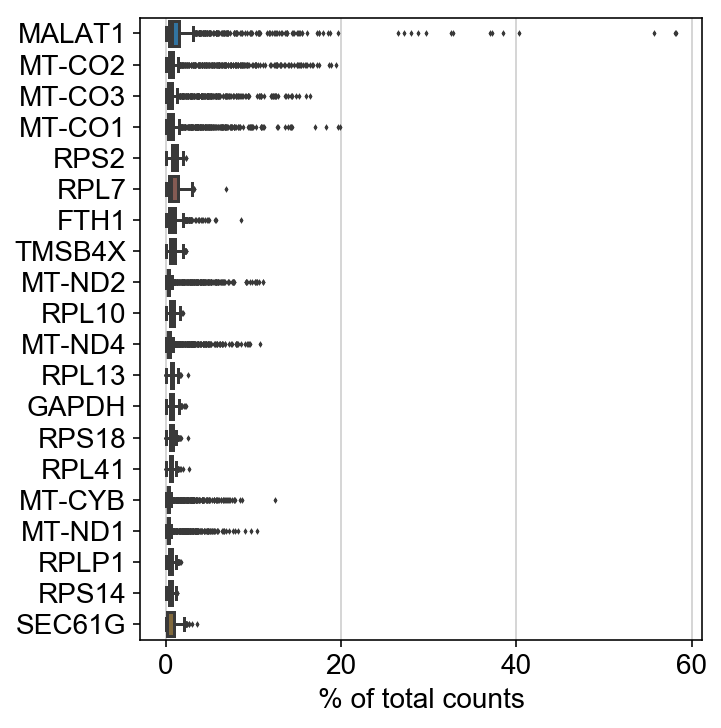

In [19]:
# Show those genes that yield the highest fraction of counts in each single cells, across all cells
sc.pl.highest_expr_genes(adata, n_top=20)

In [20]:
# Filter out cells with less than 200 genes and genes that are detected less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 3 cells that haveless than 200 genes expressed


Trying to set attribute `.obs` of view, making a copy.


filtered out 15781 genes that are detectedin less than 3 cells


### 2. Quality Control of mitochondrial genes
High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [21]:
# Get the MI percentage of each cell
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

... storing 'feature_types' as categorical


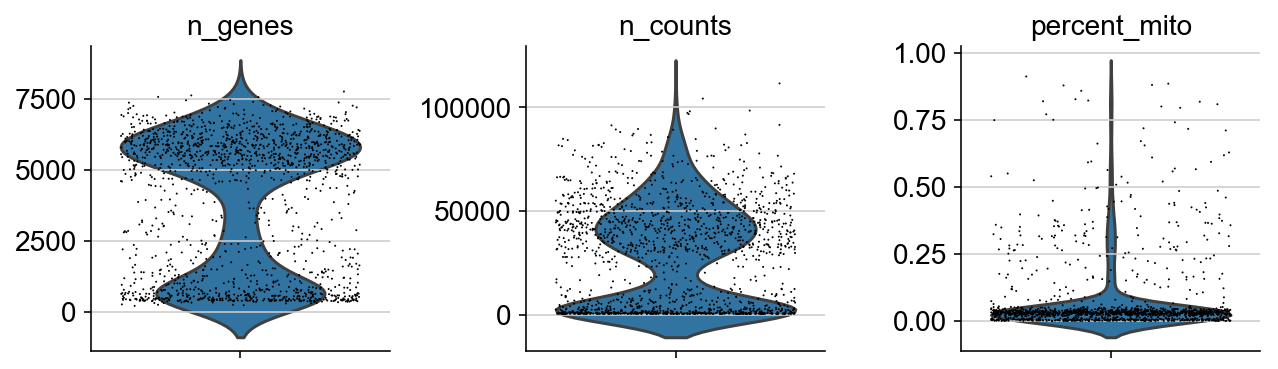

In [22]:
# Computed quality measures
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

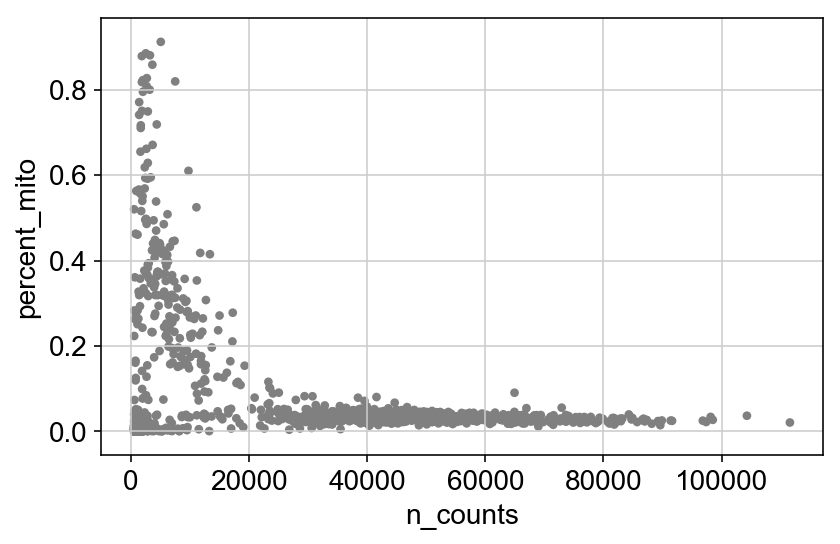

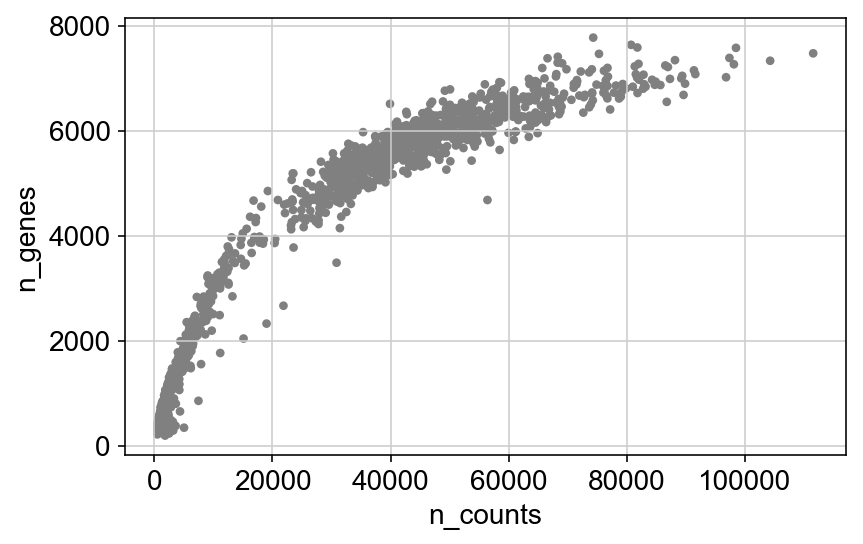

In [23]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [24]:
# Do the filtering
adata = adata[adata.obs['n_genes'] > 2500, :]
adata = adata[adata.obs['n_genes'] < 8000, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [25]:
# Normalize total counts to 10,000 reads per cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# logarithmic the data
sc.pp.log1p(adata)

normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [26]:
adata.raw = adata

### 3. Identify highly-variable genes

In [27]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


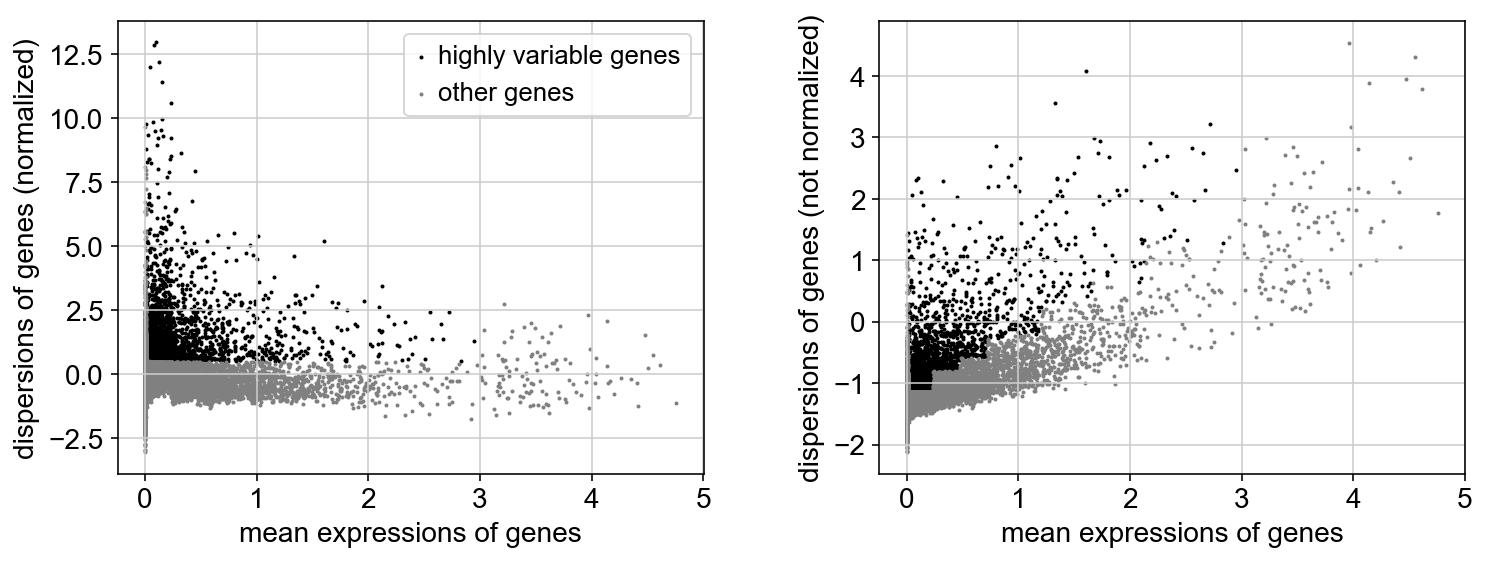

In [28]:
sc.pl.highly_variable_genes(adata)

In [29]:
adata = adata[:, adata.var['highly_variable']]

In [30]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


# Run PCA and embed the graph

### 1. PCA

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


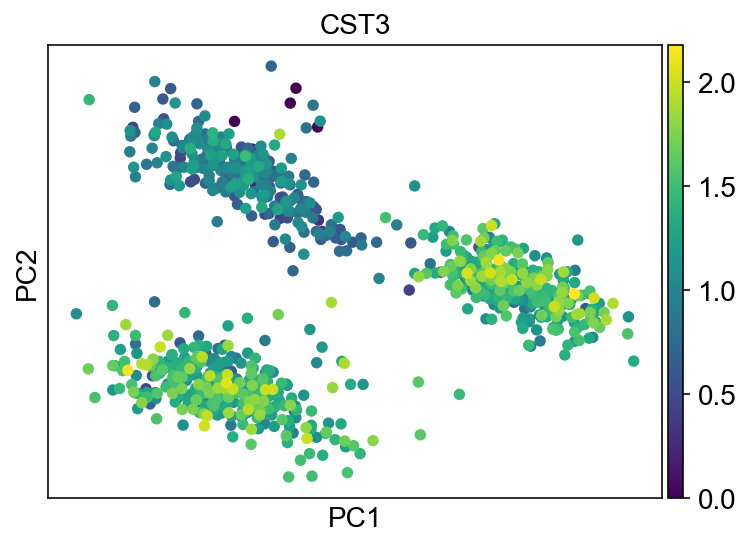

In [31]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

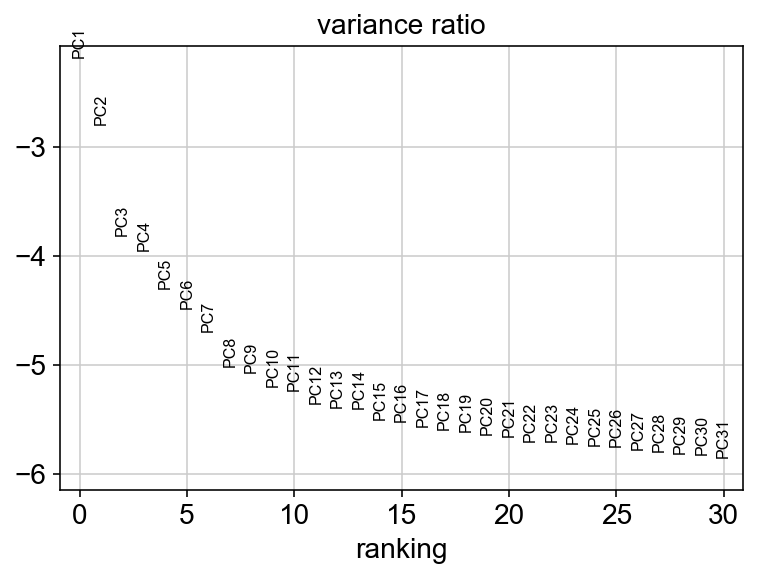

In [32]:
sc.pl.pca_variance_ratio(adata, log=True)

### 2. Compute the neighborhood graph and embed it

In [177]:
# Calculate the neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# use UMAP to embed the graph
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


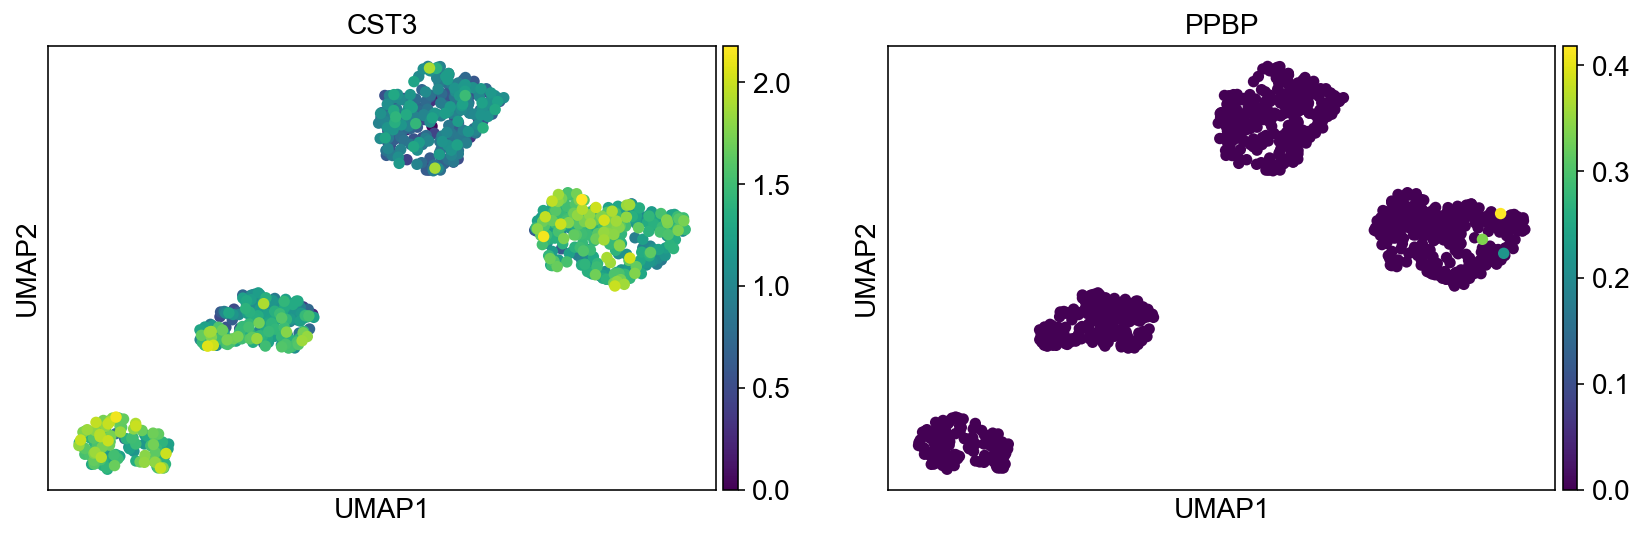

In [178]:
sc.pl.umap(adata, color=['CST3', 'PPBP'])

# Clustering the neighborhood graph

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


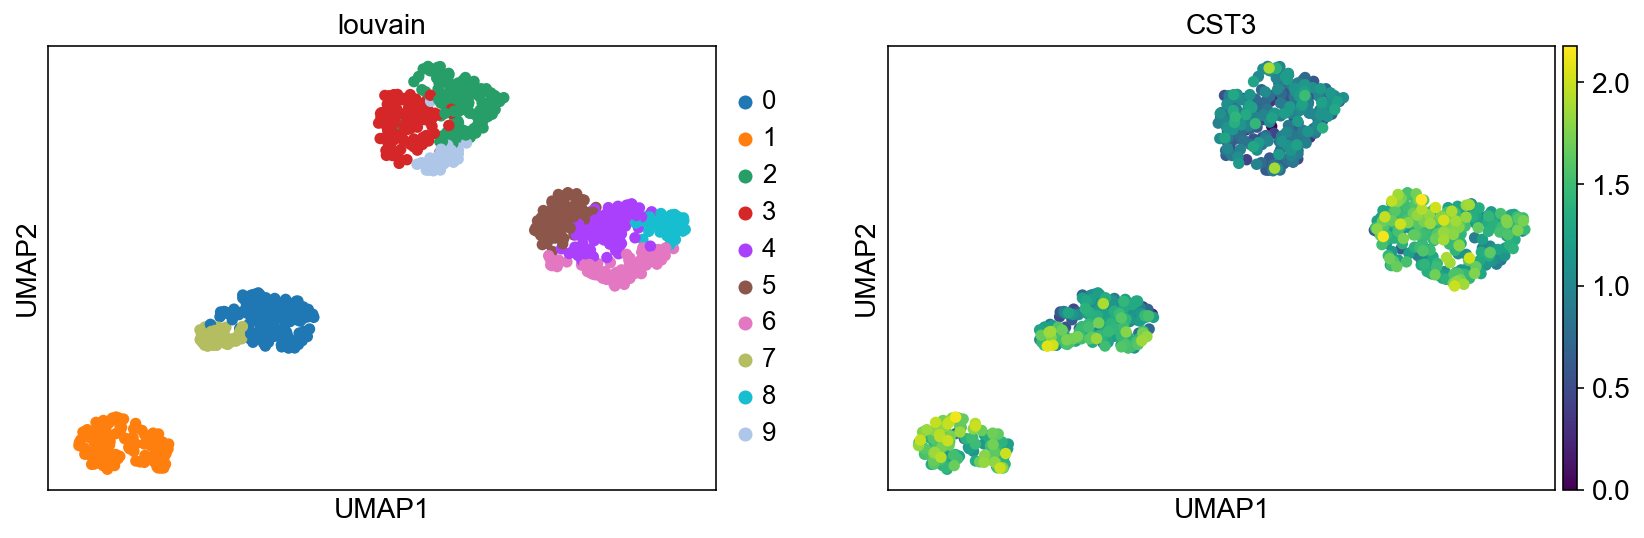

In [179]:
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain', 'CST3'], show=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


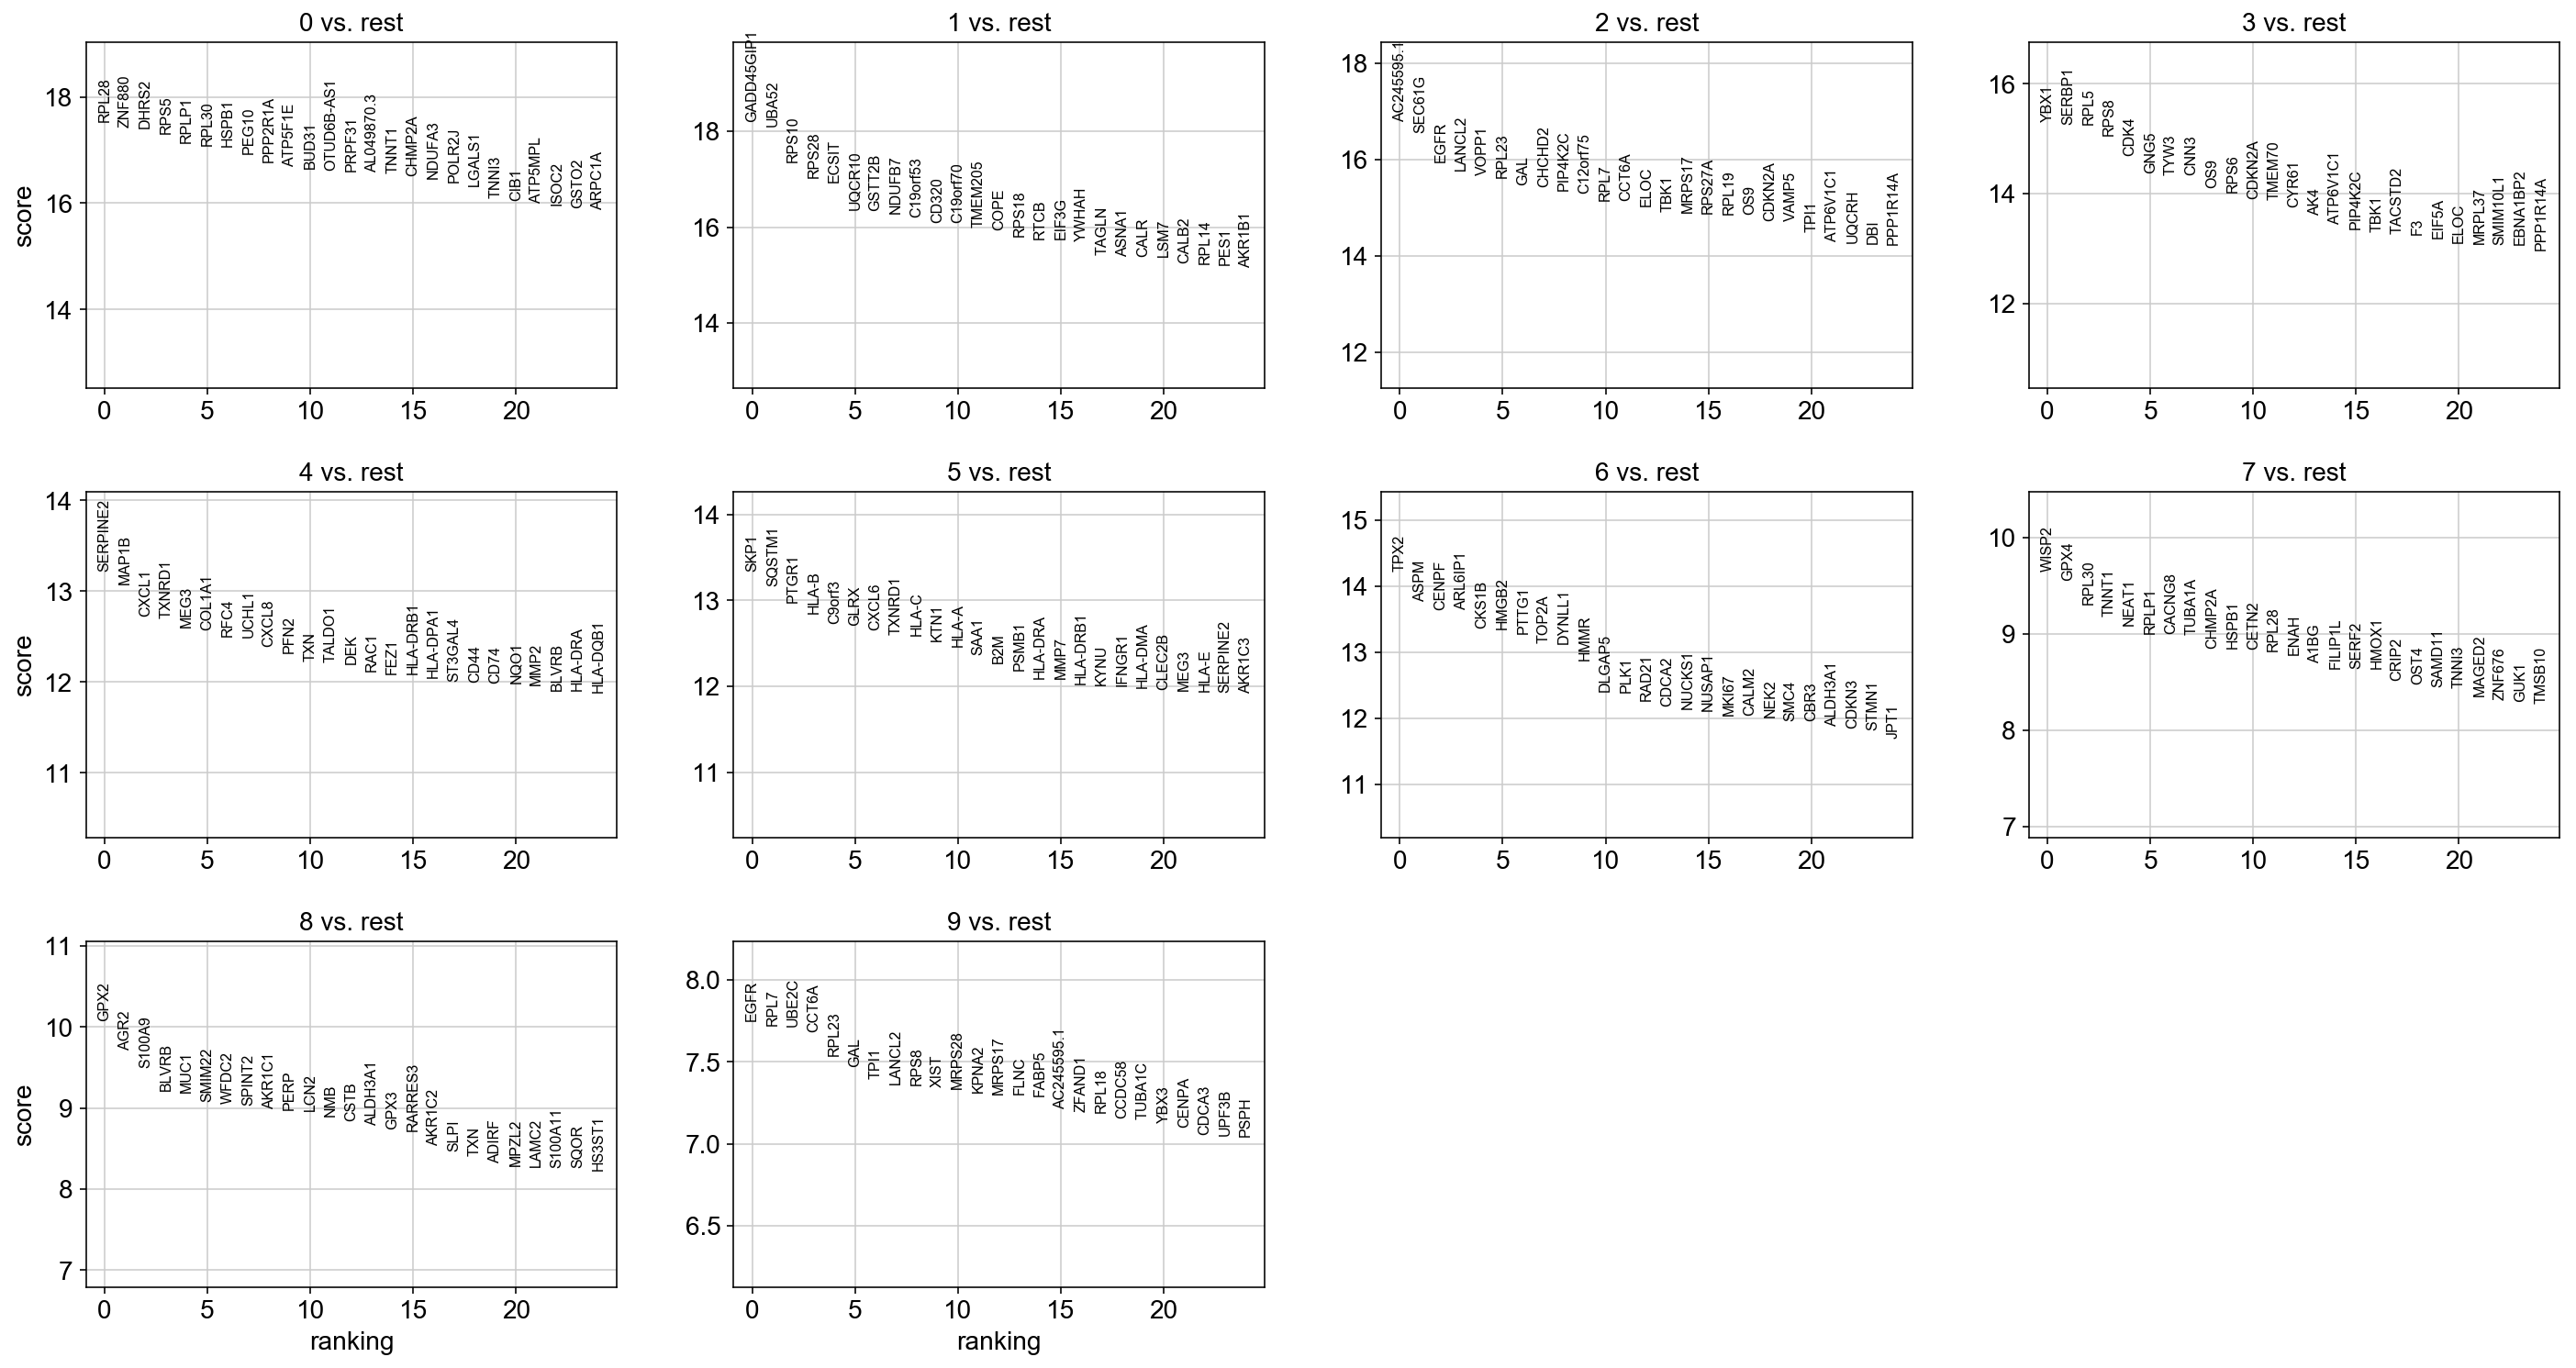

In [36]:
# Find the remarkable genes
# method: t-test, wilcoxon, logreg
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [37]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9
0,RPL28,GADD45GIP1,AC245595.1,YBX1,SERPINE2,SKP1,TPX2,WISP2,GPX2,EGFR
1,ZNF880,UBA52,SEC61G,SERBP1,MAP1B,SQSTM1,ASPM,GPX4,AGR2,RPL7
2,DHRS2,RPS10,EGFR,RPL5,CXCL1,PTGR1,CENPF,RPL30,S100A9,UBE2C
3,RPS5,RPS28,LANCL2,RPS8,TXNRD1,HLA-B,ARL6IP1,TNNT1,BLVRB,CCT6A
4,RPLP1,ECSIT,VOPP1,CDK4,MEG3,C9orf3,CKS1B,NEAT1,MUC1,RPL23


In [38]:
# Get a table with the scores and groups
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p
0,RPL28,9.011328e-69,GADD45GIP1,6.073944e-74,AC245595.1,3.572168e-63,YBX1,7.250046e-53,SERPINE2,7.015932e-40,SKP1,1.399321e-40,TPX2,6.717539e-46,WISP2,5.099056e-22,GPX2,7.040993e-24,EGFR,9.233865e-15
1,ZNF880,5.762657e-68,UBA52,3.639791e-73,SEC61G,1.625184e-61,SERBP1,1.355898e-52,MAP1B,4.428967e-39,SQSTM1,1.348347e-39,ASPM,3.810098e-43,GPX4,1.249456e-21,AGR2,2.721740e-22,RPL7,1.130698e-14
2,DHRS2,7.324057e-68,RPS10,1.509085e-67,EGFR,3.230105e-57,RPL5,1.454367e-52,CXCL1,4.518856e-37,PTGR1,1.676359e-38,CENPF,2.231407e-42,RPL30,1.305835e-20,S100A9,2.024396e-21,UBE2C,1.193935e-14
3,RPS5,3.776915e-67,RPS28,4.839944e-65,LANCL2,4.323251e-56,RPS8,2.991280e-51,TXNRD1,5.349230e-37,HLA-B,8.585475e-38,ARL6IP1,2.458808e-42,TNNT1,4.336965e-20,BLVRB,2.934874e-20,CCT6A,1.558122e-14
4,RPLP1,9.330524e-66,ECSIT,2.611586e-64,VOPP1,1.967576e-55,CDK4,8.028207e-49,MEG3,2.059961e-36,C9orf3,4.000970e-37,CKS1B,1.072588e-40,NEAT1,9.865739e-20,MUC1,3.642006e-20,RPL23,4.845533e-14


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


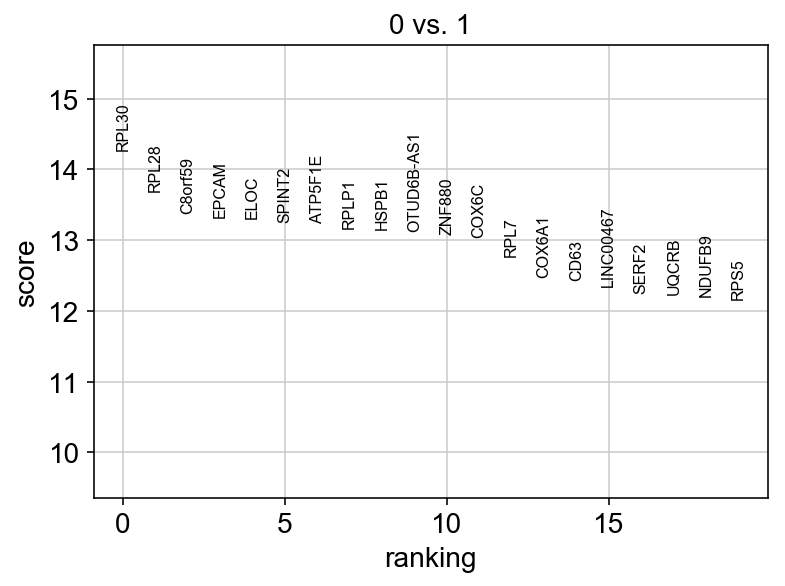

In [39]:
# Compare to a single cluster
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [40]:
adata

AnnData object with n_obs × n_vars = 916 × 2502 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

# Store cluster results and ground truth

In [41]:
data = adata.obs.reset_index()

In [42]:
data["barcode"] = data[0]
data.pop(0)
data["barcode"] = data["barcode"].map(lambda x: x[:-2])
data.head(10)

,n_genes,percent_mito,n_counts,louvain,barcode
0,6045,0.035705,42935.0,4,AAACCTGCAGACACTT
1,5940,0.041117,43242.0,1,AAAGATGCACATTTCT
2,6374,0.034224,51076.0,0,AAAGATGTCCTTTACA
3,6817,0.043408,58008.0,6,AAAGCAACATCAGTAC
4,5905,0.026871,41309.0,1,AAATGCCCACTTCGAA
5,5726,0.036780,41898.0,7,AAATGCCTCATATCGG
6,5879,0.026002,44920.0,1,AACACGTGTCAGAAGC
7,6405,0.021103,77192.0,2,AACACGTGTCGAACAG
8,5703,0.030085,34004.0,8,AACACGTTCCGCATAA
9,5591,0.037976,36049.0,5,AACCATGAGCAATCTC


In [37]:
newdata = table.merge(data, on='barcode')
newdata.head(10)

,cell_name,barcode,ref,cell_line_demuxlet,demuxlet_cls,n_genes,percent_mito,n_counts,louvain
0,CELL_000001,CCGTTCAGTACGACCC,755167,HCC827,SNG,7332,0.036494,104291.0,9
1,CELL_000002,TGAAAGACACTGTTAG,753727,HCC827,DBL,7577,0.026923,98504.0,3
2,CELL_000003,CTGAAACAGAGACTAT,750591,HCC827,SNG,7265,0.033755,98147.0,3
3,CELL_000004,GACTGCGCACGAAACG,718276,HCC827,SNG,7386,0.021819,97391.0,3
4,CELL_000005,AGCAGCCTCCTCGCAT,701393,HCC827,SNG,7018,0.025005,96822.0,9
5,CELL_000006,TTCTCAAGTTACGACT,665628,H1975,SNG,7149,0.025256,91385.0,0
6,CELL_000007,AGTGTCAGTATCTGCA,663212,HCC827,SNG,7078,0.024593,91612.0,9
7,CELL_000008,TGAGAGGAGATCGATA,656593,HCC827,SNG,6896,0.025400,89881.0,9
8,CELL_000009,TTCGAAGGTTCCGTCT,652084,HCC827,SNG,7045,0.023356,89399.0,3
9,CELL_000010,CTCATTACATTCCTCG,651956,HCC827,SNG,7213,0.023226,86973.0,3


In [38]:
newdata['target'] = newdata['cell_line_demuxlet'].factorize()[0]
newdata.head(10)

,cell_name,barcode,ref,cell_line_demuxlet,demuxlet_cls,n_genes,percent_mito,n_counts,louvain,target
0,CELL_000001,CCGTTCAGTACGACCC,755167,HCC827,SNG,7332,0.036494,104291.0,9,0
1,CELL_000002,TGAAAGACACTGTTAG,753727,HCC827,DBL,7577,0.026923,98504.0,3,0
2,CELL_000003,CTGAAACAGAGACTAT,750591,HCC827,SNG,7265,0.033755,98147.0,3,0
3,CELL_000004,GACTGCGCACGAAACG,718276,HCC827,SNG,7386,0.021819,97391.0,3,0
4,CELL_000005,AGCAGCCTCCTCGCAT,701393,HCC827,SNG,7018,0.025005,96822.0,9,0
5,CELL_000006,TTCTCAAGTTACGACT,665628,H1975,SNG,7149,0.025256,91385.0,0,1
6,CELL_000007,AGTGTCAGTATCTGCA,663212,HCC827,SNG,7078,0.024593,91612.0,9,0
7,CELL_000008,TGAGAGGAGATCGATA,656593,HCC827,SNG,6896,0.025400,89881.0,9,0
8,CELL_000009,TTCGAAGGTTCCGTCT,652084,HCC827,SNG,7045,0.023356,89399.0,3,0
9,CELL_000010,CTCATTACATTCCTCG,651956,HCC827,SNG,7213,0.023226,86973.0,3,0


In [54]:
newdata[["barcode", "louvain", "target"]].to_csv('./cluster_results/sc-10x/seurat-python.csv')

## Compare results

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# 1. seurat python 10x - 3 cells
py_10x = pd.read_csv('./cluster_results/sc-10x/seurat-python.csv')
py_10x.pop('Unnamed: 0')

# 2. seurat r 10x - 3 cells - resolution = 1
R_10x = pd.read_csv('./cluster_results/sc-10x/seurat-R-1.csv')
R_10x['barcode'] = R_10x['Unnamed: 0']
R_10x.pop('Unnamed: 0')
newdata = table.merge(R_10x, on='barcode')
newdata['target'] = newdata['cell_line_demuxlet'].factorize()[0]

# 3. seurat r 10x - 3 cells - resolution = 0.5
R_10x_half = pd.read_csv('./cluster_results/sc-10x/seurat-R.csv')
R_10x_half['barcode'] = R_10x_half['Unnamed: 0']
R_10x_half.pop('Unnamed: 0')
newdata_half = table.merge(R_10x_half, on='barcode')
newdata_half['target'] = newdata_half['cell_line_demuxlet'].factorize()[0]

### 1. Cluster counts

In [10]:
# 1. seurat python 10x - 3 cells
groups_py = py_10x.groupby(by = 'louvain')
groups_py["target"].describe()[['count']]

,count
louvain,
0,144.0
1,137.0
2,134.0
3,111.0
4,104.0
5,95.0
6,80.0
7,38.0
8,38.0


In [11]:
# 2. seurat r 10x - 3 cells - resolution = 1
groups_r = newdata.groupby(by = 'seurat_clusters')
groups_r["target"].describe()[['count']]

,count
seurat_clusters,
0,151.0
1,128.0
2,117.0
3,113.0
4,91.0
5,86.0
6,66.0
7,61.0
8,58.0


In [12]:
# 3. seurat r 10x - 3 cells - resolution = 0.5
groups_r_half = newdata_half.groupby(by = 'seurat_clusters')
groups_r_half["target"].describe()[['count']]

,count
seurat_clusters,
0,279.0
1,176.0
2,142.0
3,135.0
4,117.0
5,66.0


### 2. Compare with ground truths

In [78]:
# 1. seurat python 10x - 3 cells 
df = pd.crosstab(py_10x['target'], py_10x['louvain'])
df["sum"] = df.sum(axis=1)
df

louvain,0,1,2,3,4,5,6,7,8,9,sum
target,,,,,,,,,,,
0,0,0,134,111,0,0,0,0,0,33,278
1,144,137,0,0,0,0,0,38,0,0,319
2,0,0,0,0,104,95,80,0,38,1,318


In [79]:
# 2. seurat r 10x - 3 cells - resolution = 1
df_r = pd.crosstab(newdata['target'], newdata['seurat_clusters'])
df_r["sum"] = df_r.sum(axis=1)
df_r

seurat_clusters,0,1,2,3,4,5,6,7,8,9,sum
target,,,,,,,,,,,
0,150,128,0,0,0,0,0,0,0,0,278
1,1,0,117,0,91,0,66,0,0,44,319
2,0,0,0,113,0,86,0,61,58,0,318


In [80]:
# 3. seurat r 10x - 3 cells - resolution = 0.5
df_r_half = pd.crosstab(newdata_half['target'], newdata_half['seurat_clusters'])
df_r_half["sum"] = df_r_half.sum(axis=1)
df_r_half

seurat_clusters,0,1,2,3,4,5,sum
target,,,,,,,
0,278,0,0,0,0,0,278
1,1,0,0,135,117,66,319
2,0,176,142,0,0,0,318


### 3. Visualization

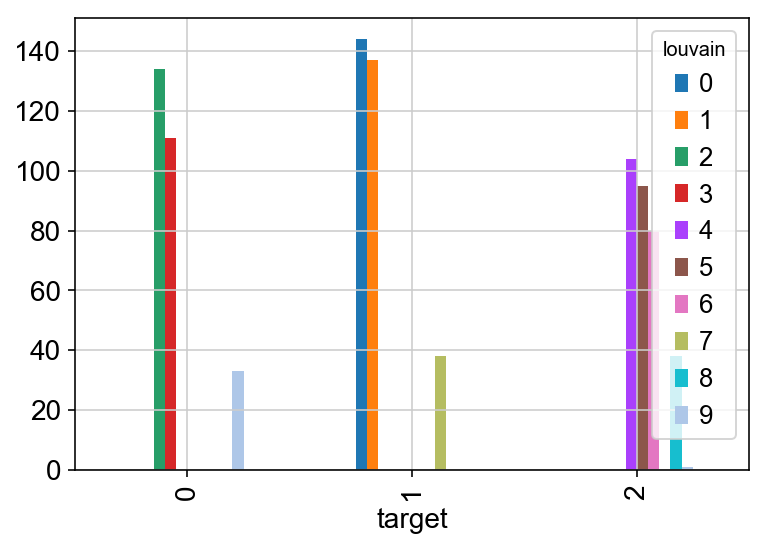

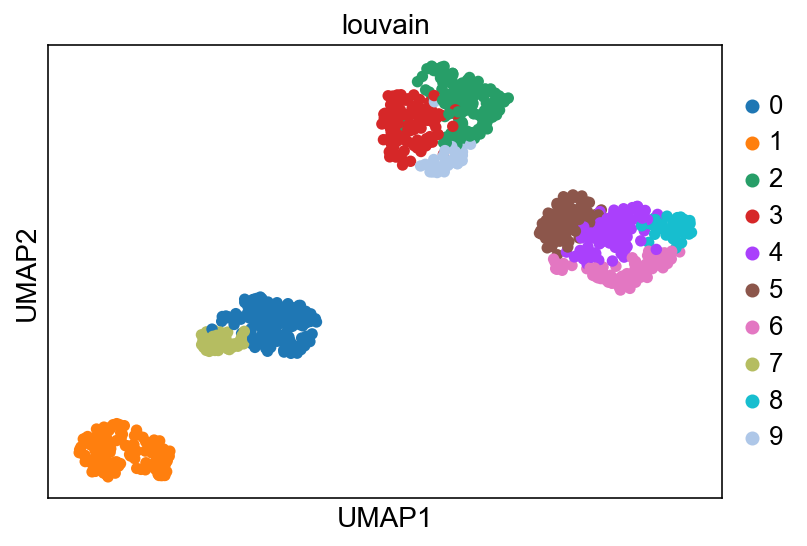

In [89]:
# 1. seurat python 10x - 3 cells 
df.plot.bar()
sc.pl.umap(adata, color=['louvain'])

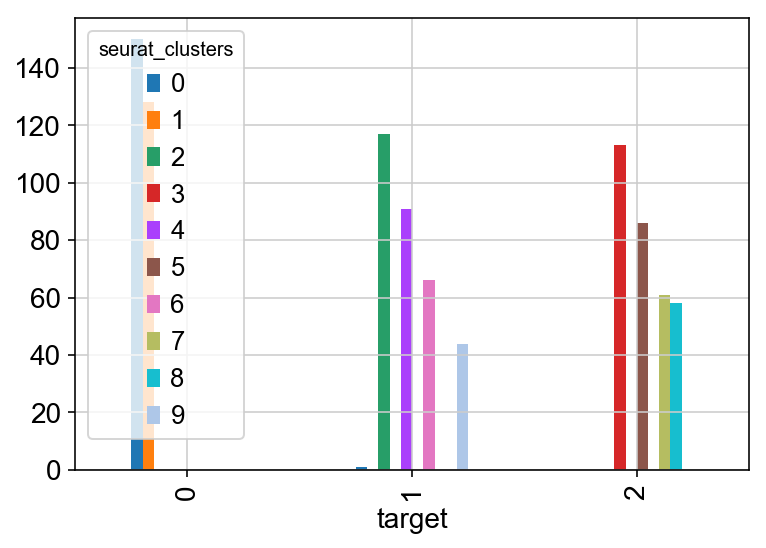

In [90]:
# 2. seurat r 10x - 3 cells - resolution = 1
df_r = pd.crosstab(newdata['target'], newdata['seurat_clusters'])
df_r.plot.bar()

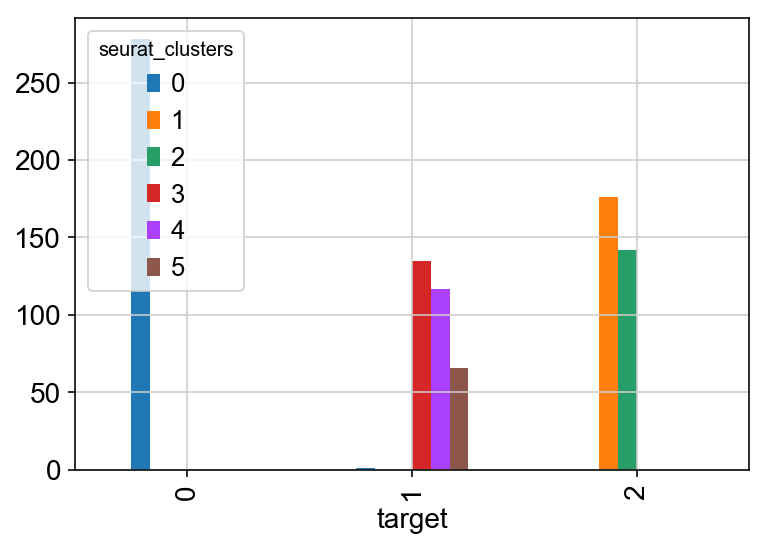

In [91]:
# 3. seurat r 10x - 3 cells - resolution = 1
df_r_half = pd.crosstab(newdata_half['target'], newdata_half['seurat_clusters'])
df_r_half.plot.bar()

### 4. Calculating the metrics
With M and N representing the cluster
assignment generated from clustering methods and annotations (ground truth), we
define these measures as follows:

<img src="photos/clustering.png"></img>

where $x_j$ are cells in the jth true cluster and $p(x_j)$ are the proportions of these
cells relative to the total number of cells in the ith generated cluster. For $H_{accuracy}$,
M denotes the clustering generated by a given method, and $Ni$ are the true clusters
in the ith generated cluster. Similarly, in $H_{purity}$, N denotes the true clusters while
$M_i$ is the method assigned cluster for the ith true cluster. The ECA measures the
diversity of the true group labels within each cluster assigned by the clustering
algorithm. A low value indicates that the cells in a cluster identified by a given
method are homogeneous and from the same group.

In [171]:
def calc_h_accuracy(df):
    df_norm = df.apply(lambda x: x/x.sum(), axis=0)
    df_entropy = df_norm.apply(lambda x: x*np.log(x+0.0001))
    return -np.sum(df_entropy.sum(axis=0)) / len(df.columns)

def calc_h_purity(df):
    df_norm = df.apply(lambda x: x/x.sum(), axis=1)
    df_entropy = df_norm.apply(lambda x: x*np.log(x+0.0001))
    return -np.sum(df_entropy.sum(axis=0)) / len(df.columns)

In [172]:
print("======10x single cell 3 cell lines results======")
print("The entropy of cluster accuracy for seurat python: {:.5f}".format(calc_h_accuracy(df)))
print("The entropy of cluster accuracy for seurat R (resolution=1): {:.5f}".format(calc_h_accuracy(df_r)))
print("The entropy of cluster accuracy for seurat R (resolution=0.5): {:.5f}".format(calc_h_accuracy(df_r_half)))

======10x single cell 3 cell lines results======
The entropy of cluster accuracy for seurat python: 0.01316
The entropy of cluster accuracy for seurat R (resolution=1): 0.00387
The entropy of cluster accuracy for seurat R (resolution=0.5): 0.00384


In [173]:
print("======10x single cell 3 cell lines results======")
print("The entropy of cluster entropy for seurat python: {:.5f}".format(calc_h_purity(df)))
print("The entropy of cluster entropy for seurat R (resolution=1): {:.5f}".format(calc_h_purity(df_r)))
print("The entropy of cluster entropy for seurat R (resolution=0.5): {:.5f}".format(calc_h_purity(df_r_half)))

======10x single cell 3 cell lines results======
The entropy of cluster entropy for seurat python: 0.32913
The entropy of cluster entropy for seurat R (resolution=1): 0.33803
The entropy of cluster entropy for seurat R (resolution=0.5): 0.29376


#### Rand index adjusted for chance

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:

$ARI = \frac{RI - Expected\{RI\}}{max(RI) - Expected\{RI\}}$

The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).

In [168]:
from sklearn.metrics.cluster import adjusted_rand_score
print("======10x single cell 3 cell lines results======")
print("The ARI for seurat python: {:.5f}".format(adjusted_rand_score(py_10x['target'], py_10x['louvain'])))
print("The ARI for seurat R (resolution=1): {:.5f}".format(adjusted_rand_score(newdata['target'], newdata['seurat_clusters'])))
print("The ARI for seurat R (resolution=0.5): {:.5f}".format(adjusted_rand_score(newdata_half['target'], newdata_half['seurat_clusters'])))

======10x single cell 3 cell lines results======
The ARI for seurat python: 0.42268
The ARI for seurat R (resolution=1): 0.40055
The ARI for seurat R (resolution=0.5): 0.65244
